# Bronze: Regel-basierte vs. NER-basierte PII-Erkennung

1. **Regel-basierte Erkennung** (Regex-Patterns)
2. **Named Entity Recognition** (NER) mit spaCy

---

## Setup

In [12]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import re
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Eigene modul/skript
from src.pii_redactor import PIIRedactor, PIIType, PIIMatch

---

## 1. Regel-basierte Erkennung (Regex)

--> **Regular Expressions (Regex)** sind Muster, die Zeichenketten beschreiben


### Erklärung der Regex

- **E-Mail (Regex):** `\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b`  
  **Erklärung:** E-Mail-Adressen (Name + `@` + Domain + Endung wie `.de/.com`)

- **Telefon (DE) (Regex):** `\b(?:\+?49[-.\/\s]?)?(?:\(?\d{2,5}\)?[-.\/\s]?)?\d{3,}[-.\/\s]?\d{2,}\b`  
  **Erklärung:** Deutsche Nummern mit optionaler Ländervorwahl (+49/49), optionaler Vorwahl (auch in Klammern) und flexiblen Trennzeichen (Leerzeichen, `-`, `.`, `/`).

- **IBAN (Regex):** `\b[A-Z]{2}\d{2}(?:\s?\d{4}){4,7}\d{0,2}\b`  
  **Erklärung:** Matcht IBANs mit Ländercode (z.B. `DE`), Prüfziffern und Zahlenblöcken mit 4 Ziffern --> egal ob mit oder ohne Leerzeichen.

- **IP-Adresse (IPv4) (Regex):** `\b(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\b`  
  **Erklärung:** Findet IPv4-Adressen wie `192.168.0.1` --> zahlen zwischen 0 & 255

- **Datum (DE-Format) (Regex):** `\b(?:0[1-9]|[12][0-9]|3[01])[./](?:0[1-9]|1[0-2])[./](?:19|20)\d{2}\b`  
  **Erklärung:** Erkennt Datumswerte im Format `TT.MM.JJJJ` oder `TT/MM/JJJJ` (Jahre 1900–2099), also z.B. `31.12.2023`.


In [13]:
REGEX_PATTERNS_EXPLAINED = {
    "E-Mail": {
        "pattern": r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b'
    },
    
    "Telefon (DE)": {
        "pattern": r'\b(?:\+?49[-.\/\s]?)?(?:\(?\d{2,5}\)?[-.\/\s]?)?\d{3,}[-.\/\s]?\d{2,}\b'
    },
    
    "IBAN": {
        "pattern": r'\b[A-Z]{2}\d{2}(?:\s?\d{4}){4,7}\d{0,2}\b'
    },
    
    "IP-Adresse (IPv4)": {
        "pattern": r'\b(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\b'
    },
    
    "Datum (DE-Format)": {
        "pattern": r'\b(?:0[1-9]|[12][0-9]|3[01])[./](?:0[1-9]|1[0-2])[./](?:19|20)\d{2}\b'
    }
}

### 1.3 Regex-Erkennung in Aktion

In [14]:
# Redactor mit regex
regex_redactor = PIIRedactor(use_ner=False)

# Beispieltext
test_text = """
Kundendaten für Bestellung #12345:

Name: Max Mustermann
E-Mail: max.mustermann@example.com
Telefon: +49 170 1234567
Alternativ: 089/12345-678
Geburtsdatum: 15.03.1990
IBAN: DE89 3704 0044 0532 0130 00
Letzte Login-IP: 192.168.1.100

Lieferadresse: Musterstraße 42, 80331 München
"""

start_time = time.time()
regex_matches = regex_redactor.detect_regex(test_text)
regex_time = time.time() - start_time

print(f"Regex-Erkennung dauerte: {regex_time*1000:.2f} ms")
print(f"\nGefundene PIIs: {len(regex_matches)}")

for match in regex_matches:
    print(f"[{match.pii_type.value.upper():12}] '{match.text}' --> PII-Position: {match.start}-{match.end}, Confidence: {match.confidence:.2f}\n")

Regex-Erkennung dauerte: 0.15 ms

Gefundene PIIs: 12
[EMAIL       ] 'max.mustermann@example.com' --> PII-Position: 66-92, Confidence: 0.95

[PHONE       ] '12345' --> PII-Position: 29-34, Confidence: 0.85

[PHONE       ] '49 170 1234567' --> PII-Position: 103-117, Confidence: 0.85

[PHONE       ] '12345-678' --> PII-Position: 134-143, Confidence: 0.85

[PHONE       ] '3704 0044 0532' --> PII-Position: 180-194, Confidence: 0.85

[PHONE       ] '0130 00' --> PII-Position: 195-202, Confidence: 0.85

[PHONE       ] '192.168' --> PII-Position: 220-227, Confidence: 0.85

[PHONE       ] '80331' --> PII-Position: 267-272, Confidence: 0.85

[IBAN        ] 'DE89 3704 0044 0532 0130' --> PII-Position: 175-199, Confidence: 0.95

[CREDIT_CARD ] '3704 0044 0532 0130 00' --> PII-Position: 180-202, Confidence: 0.80

[IP_ADDRESS  ] '192.168.1.100' --> PII-Position: 220-233, Confidence: 0.95

[DATE_OF_BIRTH] '15.03.1990' --> PII-Position: 158-168, Confidence: 0.85



---

## 2. NER-basierte Erkennung

### 2.1 Was ist Named Entity Recognition?

**Named Entity Recognition (NER)** --> benannte Entitäten im Text identifiziert und klassifizieren

| Entity-Typ | Beschreibung | Beispiele |
|------------|--------------|----------|
| PER/PERSON | Personennamen | "Max Mustermann", "Dr. Schmidt" |
| ORG | Organisationen | "Google", "Bundesregierung" |
| LOC/GPE | Orte | "München", "Deutschland" |
| DATE | Datumsangaben | "15. März", "2024" |

In [15]:
import spacy

try:
    nlp = spacy.load("de_core_news_lg")
    print("deutsches spaCy Modell geladen")
    SPACY_AVAILABLE = True
except OSError:
    print("Modell nicht gefunden!!")
    !python -m spacy download de_core_news_lg
    nlp = spacy.load("de_core_news_lg")
    SPACY_AVAILABLE = True

deutsches spaCy Modell geladen


In [16]:
# NER mit spaCy
if SPACY_AVAILABLE:
    doc = nlp(test_text)
    
    for ent in doc.ents:
        print(f"[{ent.label_:10}] '{ent.text}' (PII-Position: {ent.start_char}-{ent.end_char})")

[PER       ] 'Max Mustermann' (PII-Position: 43-57)
[MISC      ] 'DE89' (PII-Position: 175-179)
[MISC      ] 'Login-IP: 192.168.1.100

Lieferadresse' (PII-Position: 210-248)
[LOC       ] 'Musterstraße' (PII-Position: 250-262)
[LOC       ] 'München' (PII-Position: 273-280)


### 2.3 Transformer-basierte NER --> BERT

In [17]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

# Deutsches NER-Modell laden
try:
    # Kleines & schnelleres Modell
    ner_pipeline = pipeline(
        "ner",
        model="dslim/bert-base-NER",  # --> Englisches Modell, geht aber auch für namen
        aggregation_strategy="simple"
    )
    BERT_NER_AVAILABLE = True
except Exception as e:
    BERT_NER_AVAILABLE = False

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [18]:
if BERT_NER_AVAILABLE:
    # Englischer Beispieltext für BERT
    english_test = "John Smith from Microsoft contacted sarah.jones@gmail.com about the meeting in New York."
    
    start_time = time.time()
    bert_results = ner_pipeline(english_test)
    bert_time = time.time() - start_time
    
    print(f"BERT-Dauer: {bert_time*1000:.2f} ms")
    
    for entity in bert_results:
        print(f"[{entity['entity_group']:10}] '{entity['word']}' (Score: {entity['score']:.3f})")

BERT-Dauer: 518.59 ms
[PER       ] 'John Smith' (Score: 1.000)
[ORG       ] 'Microsoft' (Score: 0.999)
[LOC       ] 'New York' (Score: 0.999)


---

## 3. Vergleich: Regex vs. NER

### 3.1 Testdatensatz

In [19]:
comparison_dataset = [
    {
        "id": 1,
        "text": "Kontaktieren Sie Max Mustermann unter max.mustermann@email.de oder 0170-1234567.",
        "expected_pii": [
            {"text": "Max Mustermann", "type": "name"},
            {"text": "max.mustermann@email.de", "type": "email"},
            {"text": "0170-1234567", "type": "phone"}
        ]
    },
    {
        "id": 2,
        "text": "Die Überweisung erfolgt auf IBAN DE89 3704 0044 0532 0130 00 (Dr. Anna Weber).",
        "expected_pii": [
            {"text": "DE89 3704 0044 0532 0130 00", "type": "iban"},
            {"text": "Dr. Anna Weber", "type": "name"}
        ]
    },
    {
        "id": 3,
        "text": "Geboren am 15.03.1990 in München. IP-Adresse: 192.168.1.100",
        "expected_pii": [
            {"text": "15.03.1990", "type": "date_of_birth"},
            {"text": "München", "type": "address"},
            {"text": "192.168.1.100", "type": "ip_address"}
        ]
    },
    {
        "id": 4,
        "text": "Meeting mit Peter Schmidt und Lisa Müller von der Telekom AG.",
        "expected_pii": [
            {"text": "Peter Schmidt", "type": "name"},
            {"text": "Lisa Müller", "type": "name"},
            {"text": "Telekom AG", "type": "name"}  # --> Organisation als PII
        ]
    },
    {
        "id": 5,
        "text": "Senden Sie die Rechnung an info@musterfirma.de, z.Hd. Hr. Meier.",
        "expected_pii": [
            {"text": "info@musterfirma.de", "type": "email"},
            {"text": "Hr. Meier", "type": "name"}
        ]
    }
]

### 3.2 NER und Regex ausprobieren

In [20]:
def run_comparison(dataset: List[dict]) -> pd.DataFrame:
    
    results = []
    
    for item in dataset:
        text = item['text']
        expected = item['expected_pii']
        
        # Regex-Erkennung
        regex_start = time.time()
        regex_matches = regex_redactor.detect_regex(text)
        regex_time = time.time() - regex_start
        
        # NER-Erkennung (spaCy)
        ner_start = time.time()
        doc = nlp(text)
        ner_matches = [(ent.text, ent.label_) for ent in doc.ents]
        ner_time = time.time() - ner_start
        
        regex_found = [m.text for m in regex_matches]
        ner_found = [m[0] for m in ner_matches]
        expected_texts = [e['text'] for e in expected]
        
        # TP, FP, FN
        regex_tp = len(set(regex_found) & set(expected_texts))
        regex_fp = len(set(regex_found) - set(expected_texts))
        regex_fn = len(set(expected_texts) - set(regex_found))
        
        ner_tp = len(set(ner_found) & set(expected_texts))
        ner_fp = len(set(ner_found) - set(expected_texts))
        ner_fn = len(set(expected_texts) - set(ner_found))
        
        results.append({
            'id': item['id'],
            'text_length': len(text),
            'expected_count': len(expected),
            'regex_found': len(regex_matches),
            'regex_tp': regex_tp,
            'regex_fp': regex_fp,
            'regex_fn': regex_fn,
            'regex_time_ms': regex_time * 1000,
            'ner_found': len(ner_matches),
            'ner_tp': ner_tp,
            'ner_fp': ner_fp,
            'ner_fn': ner_fn,
            'ner_time_ms': ner_time * 1000,
            'regex_matches': regex_found,
            'ner_matches': ner_found,
            'expected': expected_texts
        })
    
    return pd.DataFrame(results)

comparison_df = run_comparison(comparison_dataset)
display(comparison_df[['id', 'expected_count', 'regex_found', 'regex_tp', 'ner_found', 'ner_tp']])

,id,expected_count,regex_found,regex_tp,ner_found,ner_tp
0,1,3,2,2,1,1
1,2,2,4,0,2,0
2,3,3,3,2,2,2
3,4,3,0,0,4,3
4,5,2,1,1,3,2


### 3.3 Metriken berechnen

- Precision = TP / (TP + FP) --> Wie viele gefundene sind korrekt?
- Recall = TP / (TP + FN)    --> Wie viele korrekte wurden gefunden?
- F1 = 2 * (P * R) / (P + R) --> Harmonisches Mittel?

In [21]:
def calculate_metrics(tp: int, fp: int, fn: int) -> dict:
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {'precision': precision, 'recall': recall, 'f1': f1}

regex_metrics = calculate_metrics(
    comparison_df['regex_tp'].sum(),
    comparison_df['regex_fp'].sum(),
    comparison_df['regex_fn'].sum()
)

ner_metrics = calculate_metrics(
    comparison_df['ner_tp'].sum(),
    comparison_df['ner_fp'].sum(),
    comparison_df['ner_fn'].sum()
)

print(f"\nRegex-basierte Erkennung:")
print(f"  Precision: {regex_metrics['precision']:.3f}")
print(f"  Recall:    {regex_metrics['recall']:.3f}")
print(f"  F1-Score:  {regex_metrics['f1']:.3f}")

print(f"\nNER-basierte Erkennung (spaCy):")
print(f"  Precision: {ner_metrics['precision']:.3f}")
print(f"  Recall:    {ner_metrics['recall']:.3f}")
print(f"  F1-Score:  {ner_metrics['f1']:.3f}")


Regex-basierte Erkennung:
  Precision: 0.500
  Recall:    0.385
  F1-Score:  0.435

NER-basierte Erkennung (spaCy):
  Precision: 0.667
  Recall:    0.615
  F1-Score:  0.640


### 3.4 Visualisierung der Ergebnisse

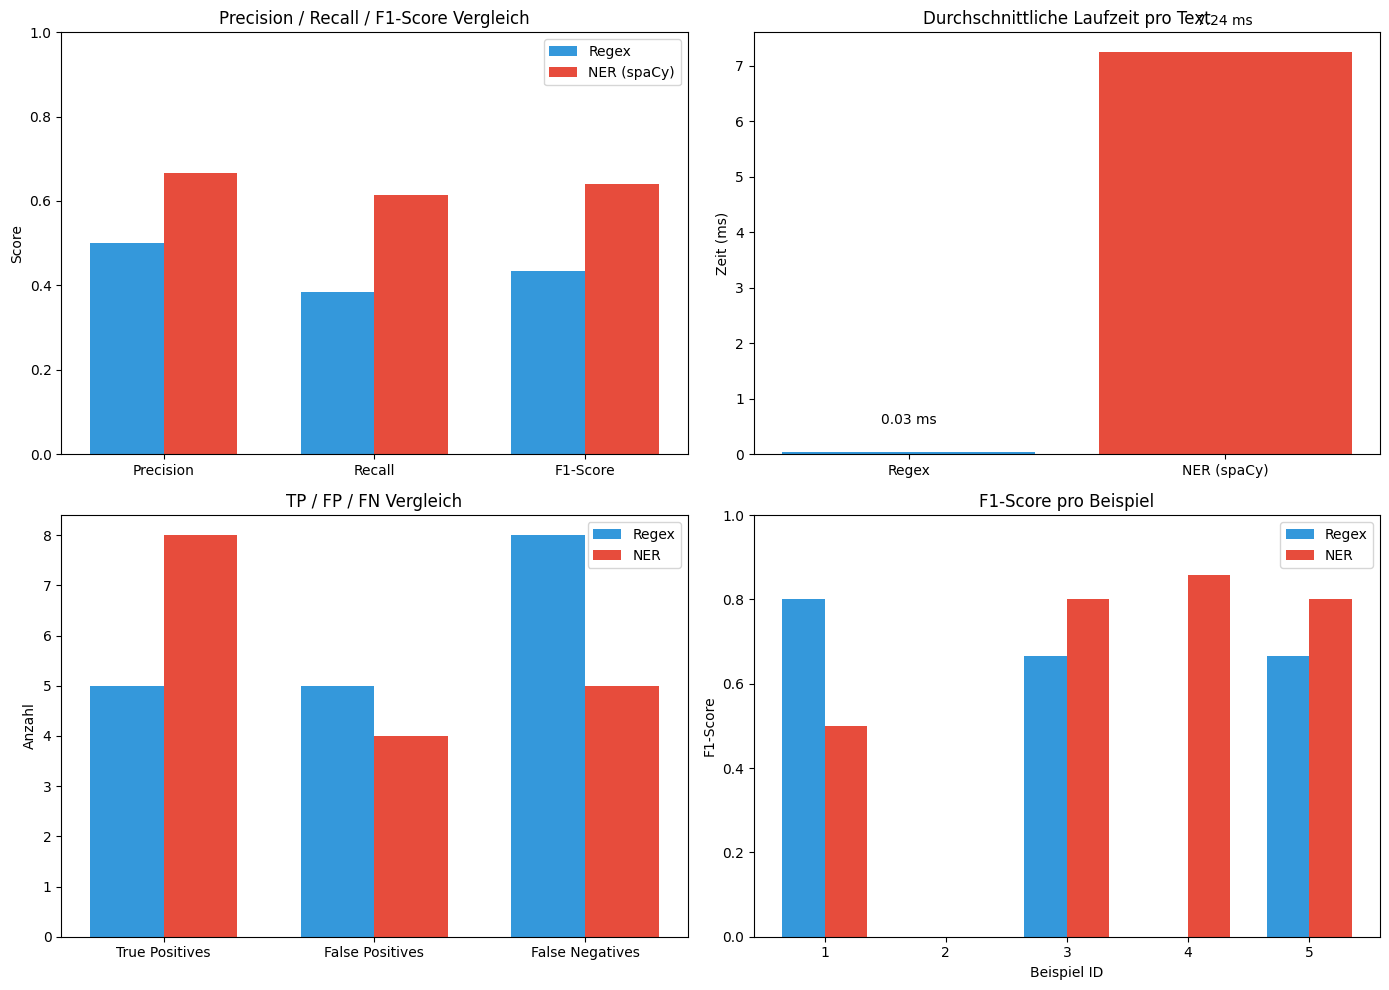

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --> Precision/Recall/F1 Vergleich
metrics_comparison = pd.DataFrame({
    'Metrik': ['Precision', 'Recall', 'F1-Score'],
    'Regex': [regex_metrics['precision'], regex_metrics['recall'], regex_metrics['f1']],
    'NER (spaCy)': [ner_metrics['precision'], ner_metrics['recall'], ner_metrics['f1']]
})

x = np.arange(len(metrics_comparison['Metrik']))
width = 0.35

axes[0, 0].bar(x - width/2, metrics_comparison['Regex'], width, label='Regex', color='#3498db')
axes[0, 0].bar(x + width/2, metrics_comparison['NER (spaCy)'], width, label='NER (spaCy)', color='#e74c3c')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Precision / Recall / F1-Score Vergleich')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_comparison['Metrik'])
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)

# 2. Laufzeit-Vergleich
time_data = {
    'Regex': comparison_df['regex_time_ms'].mean(),
    'NER (spaCy)': comparison_df['ner_time_ms'].mean()
}
colors = ['#3498db', '#e74c3c']
axes[0, 1].bar(time_data.keys(), time_data.values(), color=colors)
axes[0, 1].set_ylabel('Zeit (ms)')
axes[0, 1].set_title('Durchschnittliche Laufzeit pro Text')
for i, (method, time_val) in enumerate(time_data.items()):
    axes[0, 1].text(i, time_val + 0.5, f'{time_val:.2f} ms', ha='center')

# --> True Positives
# --> False Positives
# --> False Negatives
confusion_data = pd.DataFrame({
    'Kategorie': ['True Positives', 'False Positives', 'False Negatives'],
    'Regex': [comparison_df['regex_tp'].sum(), comparison_df['regex_fp'].sum(), comparison_df['regex_fn'].sum()],
    'NER': [comparison_df['ner_tp'].sum(), comparison_df['ner_fp'].sum(), comparison_df['ner_fn'].sum()]
})

x = np.arange(len(confusion_data['Kategorie']))
axes[1, 0].bar(x - width/2, confusion_data['Regex'], width, label='Regex', color='#3498db')
axes[1, 0].bar(x + width/2, confusion_data['NER'], width, label='NER', color='#e74c3c')
axes[1, 0].set_ylabel('Anzahl')
axes[1, 0].set_title('TP / FP / FN Vergleich')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(confusion_data['Kategorie'])
axes[1, 0].legend()

# Detailanalyse pro Beispiel
example_ids = comparison_df['id'].values
regex_f1_per_example = []
ner_f1_per_example = []

for _, row in comparison_df.iterrows():
    regex_f1 = calculate_metrics(row['regex_tp'], row['regex_fp'], row['regex_fn'])['f1']
    ner_f1 = calculate_metrics(row['ner_tp'], row['ner_fp'], row['ner_fn'])['f1']
    regex_f1_per_example.append(regex_f1)
    ner_f1_per_example.append(ner_f1)

x = np.arange(len(example_ids))
axes[1, 1].bar(x - width/2, regex_f1_per_example, width, label='Regex', color='#3498db')
axes[1, 1].bar(x + width/2, ner_f1_per_example, width, label='NER', color='#e74c3c')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_xlabel('Beispiel ID')
axes[1, 1].set_title('F1-Score pro Beispiel')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(example_ids)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(project_root / 'exports' / 'regex_vs_ner_comparison.png', dpi=150)
plt.show()

---

## 3. Hybrid-Ansatz ausprobieren

--> Regex für strukturierte Daten, NER für Namen und Orte.

In [23]:
hybrid_redactor = PIIRedactor(use_ner=True, ner_model="de_core_news_lg")

# Beispieltext
complex_text = """
Protokoll Mitarbeitergespräch

Teilnehmer: Dr. Michael Schmidt (Abteilungsleiter)
            Lisa Müller-Weber (HR)
            
Datum: 15.03.2024

Der Mitarbeiter Thomas Bauer (thomas.bauer@company.de, Tel: +49 89 123456) 
hat eine Gehaltserhöhung beantragt. Die Überweisung erfolgt auf 
IBAN DE89 3704 0044 0532 0130 00.

Nächstes Meeting in München, Leopoldstraße 42.
Remote-Zugang über VPN (IP: 10.0.0.42) möglich.
"""

# --> Alle drei Methoden vergleichen
print("VERGLEICH: Regex vs. NER vs. Hybrid")

# Regex
regex_result = hybrid_redactor.detect(complex_text, method="regex")
print(f"\nRegex-Erkennung: {len(regex_result)} PIIs gefunden")
for m in regex_result:
    print(f"   [{m.pii_type.value:15}] '{m.text}'")

# NER
ner_result = hybrid_redactor.detect(complex_text, method="ner")
print(f"\nNER-Erkennung: {len(ner_result)} PIIs gefunden")
for m in ner_result:
    print(f"   [{m.pii_type.value:15}] '{m.text}'")

# Hybrid
hybrid_result = hybrid_redactor.detect(complex_text, method="hybrid")
print(f"\nHybrid-Erkennung: {len(hybrid_result)} PIIs gefunden")
for m in hybrid_result:
    print(f"   [{m.pii_type.value:15}] '{m.text}' ({m.method})")

NER-Modell 'de_core_news_lg' erfolgreich geladen.
VERGLEICH: Regex vs. NER vs. Hybrid

Regex-Erkennung: 5 PIIs gefunden
   [date_of_birth  ] '15.03.2024'
   [email          ] 'thomas.bauer@company.de'
   [phone          ] '49 89 123456'
   [iban           ] 'DE89 3704 0044 0532 0130'
   [ip_address     ] '10.0.0.42'

NER-Erkennung: 9 PIIs gefunden
   [name           ] 'Michael Schmidt'
   [name           ] 'Lisa Müller-Weber'
   [name           ] 'HR'
   [name           ] 'Thomas Bauer'
   [name           ] 'thomas.bauer@company.de'
   [address        ] 'Tel'
   [address        ] 'DE89'
   [address        ] 'München'
   [address        ] 'Leopoldstraße'

Hybrid-Erkennung: 12 PIIs gefunden
   [name           ] 'Michael Schmidt' (ner)
   [name           ] 'Lisa Müller-Weber' (ner)
   [name           ] 'HR' (ner)
   [date_of_birth  ] '15.03.2024' (regex)
   [name           ] 'Thomas Bauer' (ner)
   [email          ] 'thomas.bauer@company.de' (regex)
   [address        ] 'Tel' (ner)
   [ph

In [24]:
# --> Maskiertes Ergebnis
redaction_result = hybrid_redactor.redact(complex_text, method="hybrid")

print("MASKIERTER TEXT (Hybrid-Ansatz)")
print(redaction_result.redacted_text)

MASKIERTER TEXT (Hybrid-Ansatz)

Protokoll Mitarbeitergespräch

Teilnehmer: Dr. [NAME_1] (Abteilungsleiter)
            [NAME_2] ([NAME_3])

Datum: [DATE_OF_BIRTH_1]

Der Mitarbeiter [NAME_4] ([EMAIL_1], [ADDRESS_1]: +[PHONE_1]) 
hat eine Gehaltserhöhung beantragt. Die Überweisung erfolgt auf 
IBAN [IBAN_1] 00.

Nächstes Meeting in [ADDRESS_2], [ADDRESS_3] 42.
Remote-Zugang über VPN (IP: [IP_ADDRESS_1]) möglich.



---

## 4. Test mit quantisiertem LLM

In [ ]:
try:
    from llama_cpp import Llama
    
    MODEL_PATH = None
    possible_paths = [
        Path.home() / ".cache" / "llama" / "llama-3.2-3b-q4km.gguf",
        Path("/pii-detection-llm/models/llama-3.2-3b-q4km/llama-3.2-3b-instruct-q4_k_m.gguf"),
    ]
    
    for path in possible_paths:
        if path.exists():
            MODEL_PATH = path
            break
    
    if MODEL_PATH:
        llm = Llama(model_path=str(MODEL_PATH), n_ctx=2048, n_threads=4, verbose=False)
        LLM_AVAILABLE = True
        print(f"Modell geladen: {MODEL_PATH.name}")
    else:
        LLM_AVAILABLE = False
except ImportError:
    LLM_AVAILABLE = False

llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64

Modell geladen: llama-3.2-3b-instruct-q4_k_m.gguf


In [26]:
def query_with_redaction(text: str, query: str, method: str = "hybrid") -> dict:
    # Maskierung
    redaction = hybrid_redactor.redact(text, method=method)
    
    # Prompt erstellen
    prompt = f"""Kontext:
{redaction.redacted_text}

Frage: {query}
Antwort:"""
    
    if LLM_AVAILABLE:
        response = llm(prompt, max_tokens=150, stop=["\n\n"])
        answer = response['choices'][0]['text'].strip()
    else:
        # Simulation --> weil kein modell geladen ist
        answer = f"[Simulierte Antwort basierend auf {len(redaction.matches)} maskierten PIIs]"
    
    return {
        'method': method,
        'pii_count': len(redaction.matches),
        'redacted_text': redaction.redacted_text,
        'answer': answer
    }

# --> Verschiedene Methoden testen
test_query = "Wer hat an dem Gespräch teilgenommen?"

for method in ["regex", "ner", "hybrid"]:
    result = query_with_redaction(complex_text, test_query, method)
    print(f"Methode: {result['method'].upper()}")
    print(f"PIIs maskiert: {result['pii_count']}")
    print(f"Antwort: {result['answer']}" if len(result['answer']) > 200 else f"Antwort: {result['answer']}")

Methode: REGEX
PIIs maskiert: 5
Antwort: Lisa Müller-Weber (HR) und Dr. Michael Schmidt (Abteilungsleiter)
Methode: NER
PIIs maskiert: 9
Antwort: Es teilten sich Dr. [NAME_1] und [NAME_2].
Methode: HYBRID
PIIs maskiert: 12
Antwort: Dr. [NAME_1] und [NAME_2] sind an dem Gespräch teilgenommen.


---

## 5. Zusammenfassung und Export

In [27]:
# Zusammenfassung erstellen
summary = {
    "notebook": "02_bronze_recognition_masking",
    "comparison_results": {
        "regex": {
            "precision": regex_metrics['precision'],
            "recall": regex_metrics['recall'],
            "f1": regex_metrics['f1'],
            "avg_time_ms": comparison_df['regex_time_ms'].mean()
        },
        "ner": {
            "precision": ner_metrics['precision'],
            "recall": ner_metrics['recall'],
            "f1": ner_metrics['f1'],
            "avg_time_ms": comparison_df['ner_time_ms'].mean()
        }
    },
    "recommendation": "hybrid",
    "test_cases": len(comparison_dataset)
}

# Export
export_path = project_root / "exports" / "notebook_02_summary.json"
with open(export_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"\nExport gespeichert: {export_path}")

print(f"\nTest-Fälle analysiert: {summary['test_cases']}")
print(f"\nRegex: F1={summary['comparison_results']['regex']['f1']:.3f}, Zeit={summary['comparison_results']['regex']['avg_time_ms']:.2f}ms")
print(f"NER:   F1={summary['comparison_results']['ner']['f1']:.3f}, Zeit={summary['comparison_results']['ner']['avg_time_ms']:.2f}ms")


Export gespeichert: /Volumes/Fanxiang S880E 2TB/M-APR/2_Semester/LLM/github-llm/pii-detection-llm/exports/notebook_02_summary.json

Test-Fälle analysiert: 5

Regex: F1=0.435, Zeit=0.03ms
NER:   F1=0.640, Zeit=7.24ms


---

## Quellen und Referenzen

1. **spaCy** - Industrial-Strength Natural Language Processing. [https://spacy.io/](https://spacy.io/)

2. **Hugging Face Transformers** - State-of-the-art NLP. [https://huggingface.co/transformers/](https://huggingface.co/transformers/)

3. **Regular Expressions** - Python re module documentation. [https://docs.python.org/3/library/re.html](https://docs.python.org/3/library/re.html)

4. **BERT NER Model** (dslim/bert-base-NER) - [https://huggingface.co/dslim/bert-base-NER](https://huggingface.co/dslim/bert-base-NER)